<a href="https://colab.research.google.com/github/yiyinglai/Pneumonia/blob/master/ipynb/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
# %tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow
from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from keras.utils import plot_model
import matplotlib.pyplot as plt
from scipy import interp
import numpy as np
import tqdm
import math
import os
import cv2
! pip install git+https://github.com/divamgupta/image-segmentation-keras.git

Using TensorFlow backend.


  Cloning https://github.com/divamgupta/image-segmentation-keras.git to /tmp/pip-req-build-icp94pv8
  Running command git clone -q https://github.com/divamgupta/image-segmentation-keras.git /tmp/pip-req-build-icp94pv8
     |████████████████████████████████| 28.3MB 33.2MB/s 
  Created wheel for keras-segmentation: filename=keras_segmentation-0.3.0-cp36-none-any.whl size=39858 sha256=3dde1eb5c4f4a650585d787349afab1d0570f3d2abd568779912ef3eafa73ea2
  Stored in directory: /tmp/pip-ephem-wheel-cache-r7mhd6xr/wheels/0a/4e/8b/d3f9088958a351a72f48ede4558836b78a03c0c124f81f41ed
Successfully built keras-segmentation
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 3.4.7.28
    Uninstalling opencv-python-3.4.7.28:
      Successfully uninstalled opencv-python-3.4.7.28


**Prepare data**

In [0]:
# https://lhncbc.nlm.nih.gov/publication/pub9356

# DATASET

left_path = '/content/gdrive/My Drive/ECE1512/MontgomerySet/ManualMask/leftMask'
right_path = '/content/gdrive/My Drive/ECE1512/MontgomerySet/ManualMask/rightMask'
cxr_path = '/content/gdrive/My Drive/ECE1512/MontgomerySet/CXR_png'
mask_path = '/content/gdrive/My Drive/ECE1512/MontgomerySet/Mask'
cxr_dirs = os.listdir(cxr_path)

if not os.path.exists(mask_path):
  for item in cxr_dirs:
    try:
      left = cv2.imread(os.path.join(left_path, item))
      right = cv2.imread(os.path.join(right_path, item))
      mask = cv2.add(left, right)
      cv2.imwrite(mask_path + '/' + item, mask)
    except:
      continue

In [0]:
# PREPARE DATASET FOR keras_segmentation
from math import ceil
from tqdm import tqdm

cxr_dirs = os.listdir('/content/gdrive/My Drive/ECE1512/MontgomerySet/CXR_png')
segmentation_train_size = ceil(len(cxr_dirs) * 0.9)

if cxr_dirs:
  idx = 0
  pbar = tqdm(total=len(cxr_dirs))
  for item in cxr_dirs:
    try:
      if idx < segmentation_train_size:
        image = cv2.resize(cv2.imread(os.path.join(cxr_path, item)), (473, 473))
        cv2.imwrite(os.path.join('/content/gdrive/My Drive/ECE1512/MontgomerySet/dataset/train_images', item), image)
        mask = cv2.resize(cv2.imread(os.path.join(mask_path, item)), (473, 473))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(mask,100,255,cv2.THRESH_BINARY)
        mask = np.repeat(np.expand_dims(mask/255, axis=-1), repeats=3, axis=2)
        cv2.imwrite(os.path.join('/content/gdrive/My Drive/ECE1512/MontgomerySet/dataset/train_segmentation', item), mask)
      else:
        image = cv2.resize(cv2.imread(os.path.join(cxr_path, item)), (473, 473))
        cv2.imwrite(os.path.join('/content/gdrive/My Drive/ECE1512/MontgomerySet/dataset/val_images', item), image)
        mask = cv2.resize(cv2.imread(os.path.join(mask_path, item)), (473, 473))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(mask,100,255,cv2.THRESH_BINARY)
        mask = np.repeat(np.expand_dims(mask/255, axis=-1), repeats=3, axis=2)
        cv2.imwrite(os.path.join('/content/gdrive/My Drive/ECE1512/MontgomerySet/dataset/val_segmentation', item), mask)
    except:
      print("failed at " + item)
      continue
    finally:
      idx += 1
      pbar.update(1)
  pbar.close()

**Define visualization functions**

In [0]:
# DEFINE FUNCTION TO VISUALIZE SEGMENTATION RESULTS on MontgomerySet and cxr
import cv2
import os
import random

def visualize_MS_segmentation(model_to_visualize, dataset="MontgomerySet", subset="val", idx=0):
  dirs = os.listdir(os.path.join('/content/gdrive/My Drive/ECE1512', dataset, 'dataset', (subset + '_images')))
  image_name = dirs[idx]
  x = cv2.resize(cv2.imread(os.path.join('/content/gdrive/My Drive/ECE1512', dataset, 'dataset', (subset + '_images'), image_name)), (473, 473))
  ground_truth = cv2.resize(cv2.imread(os.path.join('/content/gdrive/My Drive/ECE1512', dataset, 'dataset', (subset + '_segmentation'), image_name)), (473, 473))
  ground_truth[ground_truth == 1] = 255
  y = model_to_visualize.predict_segmentation(x)
  y[y == 1] = 255
  # show image and segmentation
  plt.figure(figsize=(10,10))
  plt.subplot(1,3,1)
  plt.title(dataset + ' ' + subset + ' image x')
  plt.imshow(x)
  plt.subplot(1,3,2)
  plt.title(dataset + ' ' + subset + ' segmentation y')
  plt.imshow(y, cmap='gray')
  plt.subplot(1,3,3)
  plt.title(dataset + ' ' + subset + ' ground truth')
  _ = plt.imshow(ground_truth, cmap='gray')

def visualize_cxr_segmentation(model_to_visualize, dataset="chest_xray", subset="train", idx=0):
  plt.figure(figsize=(10,10))
  for i, subfolder in enumerate(['bacteria', 'normal', 'virus']):
    dirs = os.listdir(os.path.join('/content/gdrive/My Drive/ECE1512', dataset, subset, subfolder))
    image_name = dirs[idx]
    x = cv2.resize(cv2.imread(os.path.join('/content/gdrive/My Drive/ECE1512', dataset, subset, subfolder, image_name)), (473, 473))
    # ground_truth = cv2.resize(cv2.imread(os.path.join('/content/gdrive/My Drive/ECE1512', dataset, subset, subfolder, image_name)), (473, 473))
    # ground_truth[ground_truth == 1] = 255
    y = model_to_visualize.predict_segmentation(x)
    y[y == 1] = 255
    # show image and segmentation
    plt.subplot(3,2,i*2+1)
    plt.title(dataset + ' ' + subset + ' ' + subfolder + ' image x')
    plt.imshow(x)
    plt.subplot(3,2,i*2+2)
    plt.title(dataset + ' ' + subset + ' ' + subfolder + ' segmentation y')
    plt.imshow(y, cmap='gray')

**Define some segmentation models**

In [0]:
# TRY SOME SEGMENTATION MODELS
from keras_segmentation.models.segnet import segnet
from keras_segmentation.models.pspnet import pspnet_50, pspnet_101

lungseg_segnet = segnet(n_classes=2, input_height=473, input_width=473, encoder_level=3)
lungseg_pspnet50 = pspnet_50(n_classes=2, input_height=473, input_width=473)
lungseg_pspnet101 = pspnet_101(n_classes=2, input_height=473, input_width=473)
















Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


**Lungseg_segnet**

In [0]:
lungseg_segnet.summary()
# plot_model(lungset_segnet, show_shapes=True)

In [0]:
# TRAIN lungseg_segnet
lungseg_segnet_history = lungseg_segnet.train(
    train_images='/content/gdrive/My Drive/ECE1512/MontgomerySet/dataset/train_images',
    train_annotations='/content/gdrive/My Drive/ECE1512/MontgomerySet/dataset/train_segmentation',
    checkpoints_path='/content/gdrive/My Drive/ECE1512/MontgomerySet/lungseg_segnet/lungseg_segnet_weights.hdf5',
    epochs=50,
    batch_size=2,
    validate=True,
    val_images='/content/gdrive/My Drive/ECE1512/MontgomerySet/dataset/val_images',
    val_annotations='/content/gdrive/My Drive/ECE1512/MontgomerySet/dataset/val_segmentation',
    auto_resume_checkpoint=True,
    steps_per_epoch=63)



Loading the weights from latest checkpoint  /content/gdrive/My Drive/ECE1512/MontgomerySet/lungseg_segnet/lungseg_segnet_weights.hdf5.9
Verifying training dataset


100%|██████████| 125/125 [01:39<00:00,  1.25it/s]


Dataset verified! 
Verifying validation dataset


100%|██████████| 13/13 [00:09<00:00,  1.30it/s]

Dataset verified! 
Starting Epoch  0
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Epoch 1/1
63/63 [==============================] - 45s 712ms/step - loss: 0.0409 - acc: 0.9848 - val_loss: 0.0369 - val_acc: 0.9848
saved  /content/gdrive/My Drive/ECE1512/MontgomerySet/lungseg_segnet/lungseg_segnet_weights.hdf5.model.0
Finished Epoch 0
Starting Epoch  1
Epoch 1/1
63/63 [==============================] - 35s 548ms/step - loss: 0.0689 - acc: 0.9750 - val_loss: 0.0400 - val_acc: 0.9838
saved  /content/gdrive/My Drive/ECE1512/MontgomerySet/lungseg_segnet/lungseg_segnet_weights.hdf5.model.1
Finished Epoch 1
Starting Epoch  2
Epoch 1/1
63/63 [==============================] - 34s 546ms/step - loss: 0.0406 - acc: 0.9848 - val_loss: 0.5812 - val_acc: 0.8661
saved  /content/gdrive/My Drive/ECE1512/MontgomerySet/lungseg_segnet/lungseg_segnet_weights.hdf5.model.2
Finished Epoch 2
Starting Epoch  3
Epoch 1/1
63/63 [==============================] - 35s 548ms/step - loss: 0.0374 - acc: 0.9861 - val_loss: 0.0377 - val_acc: 0.9839
saved  /content/gdrive/My Drive/ECE1512/Montgomery

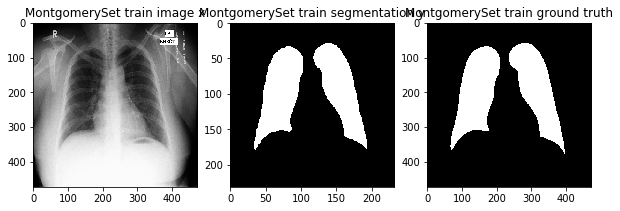

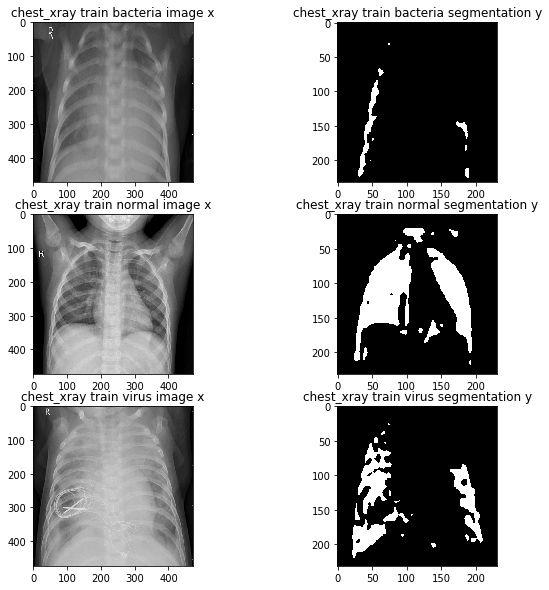

In [0]:
# VISUALIZEE SEGMENTATION RESULTS ON MontgomerySet and cxr
visualize_MS_segmentation(lungseg_segnet, subset='train', idx=1)
visualize_cxr_segmentation(lungseg_segnet, subset='train', idx=1)

**Lungseg_pspnet50**

In [0]:
plot_model(lungseg_pspnet50, show_shapes=True)

In [0]:
# TRAIN lungseg_pspnet50

lungseg_pspnet50_history = lungseg_pspnet50.train(
    train_images='/content/gdrive/My Drive/ECE1512/MontgomerySet/dataset/train_images',
    train_annotations='/content/gdrive/My Drive/ECE1512/MontgomerySet/dataset/train_segmentation',
    checkpoints_path='/content/gdrive/My Drive/ECE1512/MontgomerySet/lungseg_pspnet50/lungseg_pspnet50_weights.hdf5',
    epochs=50,
    batch_size=2,
    validate=True,
    val_images='/content/gdrive/My Drive/ECE1512/MontgomerySet/dataset/val_images',
    val_annotations='/content/gdrive/My Drive/ECE1512/MontgomerySet/dataset/val_segmentation',
    auto_resume_checkpoint=False,
    steps_per_epoch=63)

  6%|▌         | 7/125 [00:00<00:01, 63.38it/s]

Verifying training dataset


100%|██████████| 13/13 [00:00<00:00, 67.68it/s]


Dataset verified! 
Verifying validation dataset
Dataset verified! 
Starting Epoch  0
Epoch 1/1
63/63 [==============================] - 192s 3s/step - loss: 0.4346 - acc: 0.8292 - val_loss: 0.1804 - val_acc: 0.9227
saved  /content/gdrive/My Drive/ECE1512/MontgomerySet/lungseg_pspnet50/lungseg_pspnet50_weights.hdf5.model.0
Finished Epoch 0
Starting Epoch  1
Epoch 1/1
63/63 [==============================] - 168s 3s/step - loss: 0.1222 - acc: 0.9522 - val_loss: 0.5490 - val_acc: 0.8979
saved  /content/gdrive/My Drive/ECE1512/MontgomerySet/lungseg_pspnet50/lungseg_pspnet50_weights.hdf5.model.1
Finished Epoch 1
Starting Epoch  2
Epoch 1/1
63/63 [==============================] - 168s 3s/step - loss: 0.0880 - acc: 0.9658 - val_loss: 0.0728 - val_acc: 0.9695
saved  /content/gdrive/My Drive/ECE1512/MontgomerySet/lungseg_pspnet50/lungseg_pspnet50_weights.hdf5.model.2
Finished Epoch 2
Starting Epoch  3
Epoch 1/1
63/63 [==============================] - 168s 3s/step - loss: 0.0629 - acc: 0.9749 

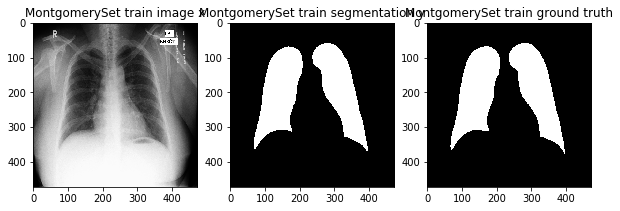

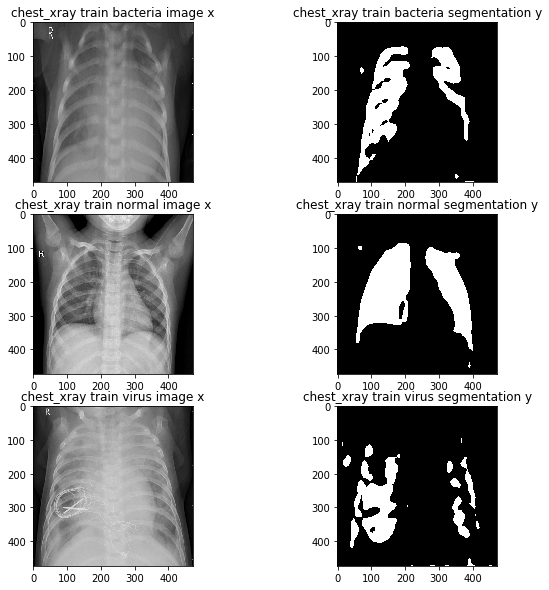

In [0]:
# VISUALIZEE SEGMENTATION RESULTS ON MontgomerySet and cxr
visualize_MS_segmentation(lungseg_pspnet50, subset='train', idx=1)
visualize_cxr_segmentation(lungseg_pspnet50, subset='train', idx=1)

**Lungseg_pspnet101**

In [0]:
plot_model(lungseg_pspnet101, show_shapes=True)

In [0]:
# TRAIN lungseg_pspnet101

lungseg_pspnet101_history = lungseg_pspnet101.train(
    train_images='/content/gdrive/My Drive/ECE1512/MontgomerySet/dataset/train_images',
    train_annotations='/content/gdrive/My Drive/ECE1512/MontgomerySet/dataset/train_segmentation',
    checkpoints_path='/content/gdrive/My Drive/ECE1512/MontgomerySet/lungseg_pspnet101/lungseg_pspnet101_weights.hdf5',
    epochs=10,
    batch_size=2,
    validate=True,
    val_images='/content/gdrive/My Drive/ECE1512/MontgomerySet/dataset/val_images',
    val_annotations='/content/gdrive/My Drive/ECE1512/MontgomerySet/dataset/val_segmentation',
    auto_resume_checkpoint=False,
    steps_per_epoch=63)

  6%|▌         | 7/125 [00:00<00:01, 68.90it/s]

Verifying training dataset


 46%|████▌     | 6/13 [00:00<00:00, 59.64it/s]

Dataset verified! 
Verifying validation dataset


100%|██████████| 13/13 [00:00<00:00, 60.78it/s]


Dataset verified! 
Starting Epoch  0
Epoch 1/1
63/63 [==============================] - 307s 5s/step - loss: 0.1830 - acc: 0.9241 - val_loss: 0.0919 - val_acc: 0.9648
saved  /content/gdrive/My Drive/ECE1512/MontgomerySet/lungseg_pspnet101/lungseg_pspnet101_weights.hdf5.model.0
Finished Epoch 0
Starting Epoch  1
Epoch 1/1
63/63 [==============================] - 262s 4s/step - loss: 0.1044 - acc: 0.9587 - val_loss: 0.0637 - val_acc: 0.9747
saved  /content/gdrive/My Drive/ECE1512/MontgomerySet/lungseg_pspnet101/lungseg_pspnet101_weights.hdf5.model.1
Finished Epoch 1
Starting Epoch  2
Epoch 1/1
63/63 [==============================] - 262s 4s/step - loss: 0.0775 - acc: 0.9698 - val_loss: 0.0597 - val_acc: 0.9757
saved  /content/gdrive/My Drive/ECE1512/MontgomerySet/lungseg_pspnet101/lungseg_pspnet101_weights.hdf5.model.2
Finished Epoch 2
Starting Epoch  3
Epoch 1/1
63/63 [==============================] - 261s 4s/step - loss: 0.0572 - acc: 0.9773 - val_loss: 0.0816 - val_acc: 0.9688
saved

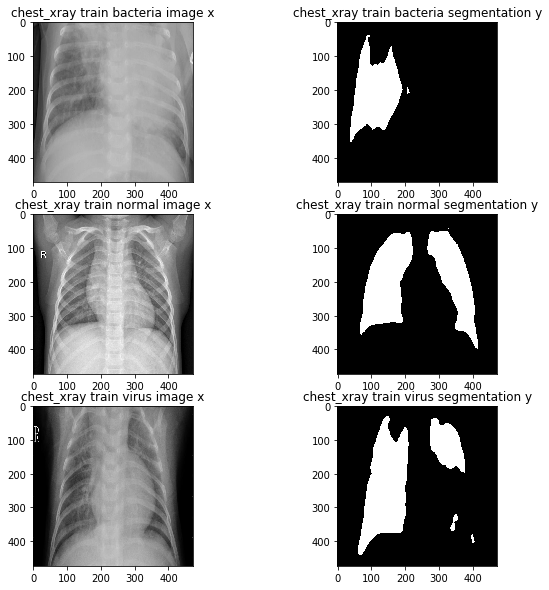

In [0]:
# VISUALIZEE SEGMENTATION RESULTS ON MontgomerySet and cxr
# visualize_MS_segmentation(lungseg_pspnet101, subset='train')
visualize_cxr_segmentation(lungseg_pspnet101, subset='train')

**lungseg**

In [0]:
# https://divamgupta.com/image-segmentation/2019/06/06/deep-learning-semantic-segmentation-keras.html

# LOAD PRETRAINED SEGMENTATION MODEL pspnest_101_voc12
from keras_segmentation.pretrained import pspnet_101_voc12
from keras.utils import plot_model

pspnet_101 = pspnet_101_voc12() # load the pretrained model trained on Pascal VOC 2012 dataset
# pspnet_101.summary()
# plot_model(pspnet_101, show_shapes=True)

In [0]:
# BUILD NEW SEGMENTATION MODEL lungseg BASED ON pspnet_101
from types import MethodType
from keras import metrics
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Conv2D, Reshape, Dense, Softmax, Activation
from keras_segmentation.models._pspnet_2 import Interp
from keras_segmentation.models.model_utils import get_segmentation_model, resize_image
from keras_segmentation.train import train
from keras_segmentation.predict import predict, predict_multiple, evaluate

# make adjustment to pspnet_101
# add a global spatial average pooling layer
x = pspnet_101.layers[-5]
x = Conv2D(2, (1, 1), strides=(1, 1), name="last_conv")(x.output)
x = Interp([473, 473], name='last_interp')(x)

# ...get_segmentation_model...
o = (Reshape((473*473, -1)))(x)
o = (Activation('softmax'))(o)
lungseg = Model(inputs=pspnet_101.input, outputs=o)
lungseg.n_classes = 2
lungseg.input_height = 473
lungseg.input_width = 473
lungseg.output_height = 473
lungseg.output_width = 473
lungseg.model_name = "pspnet_101"
lungseg.train = MethodType(train, lungseg)
lungseg.predict_segmentation = MethodType(predict, lungseg)
lungseg.predict_multiple = MethodType(predict_multiple, lungseg)
lungseg.evaluate_segmentation = MethodType(evaluate, lungseg)

# freeze pspnet_101 layers before concatenation layer
for layer in pspnet_101.layers[:-8]:
   layer.trainable = False
# train all layers
for layer in lungseg.layers:
   layer.trainable = True
# rmsprop optimizer of lungseg
rmsprop = RMSprop()
# compile the model (should be done *after* setting layers to non-trainable)
lungseg.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=[metrics.binary_accuracy])
# lungseg.summary()
# plot_model(lungseg, show_shapes=True)

In [0]:
# TRAIN lungseg MODEL on MontgomerySet
from keras.callbacks import ModelCheckpoint

lungseg_history = lungseg.train(
    train_images='/content/gdrive/My Drive/ECE1512/MontgomerySet/dataset/train_images',
    train_annotations='/content/gdrive/My Drive/ECE1512/MontgomerySet/dataset/train_segmentation',
    checkpoints_path='/content/gdrive/My Drive/ECE1512/MontgomerySet/lungseg/lungseg_weights.hdf5',
    epochs=1,
    batch_size=2,
    validate=True,
    val_images='/content/gdrive/My Drive/ECE1512/MontgomerySet/dataset/val_images',
    val_annotations='/content/gdrive/My Drive/ECE1512/MontgomerySet/dataset/val_segmentation',
    steps_per_epoch=63)

  6%|▋         | 8/125 [00:00<00:01, 79.49it/s]

Verifying training dataset


100%|██████████| 13/13 [00:00<00:00, 67.01it/s]

Dataset verified! 
Verifying validation dataset


Dataset verified! 
Starting Epoch  0
Epoch 1/1
63/63 [==============================] - 294s 5s/step - loss: 0.0349 - acc: 0.9877 - val_loss: 0.0236 - val_acc: 0.9906
saved  /content/gdrive/My Drive/ECE1512/MontgomerySet/lungseg_weights.hdf5.model.0
Finished Epoch 0


In [0]:
# LOAD lungseg
from keras_segmentation.models.pspnet import pspnet_101

# re-create a fresh new pspnet_101 model and load weights
lungseg = pspnet_101(n_classes=2, input_height=473, input_width=473)
lungseg.load_weights('/content/gdrive/My Drive/ECE1512/MontgomerySet/lungseg/lungseg_weights.hdf5.0')















Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


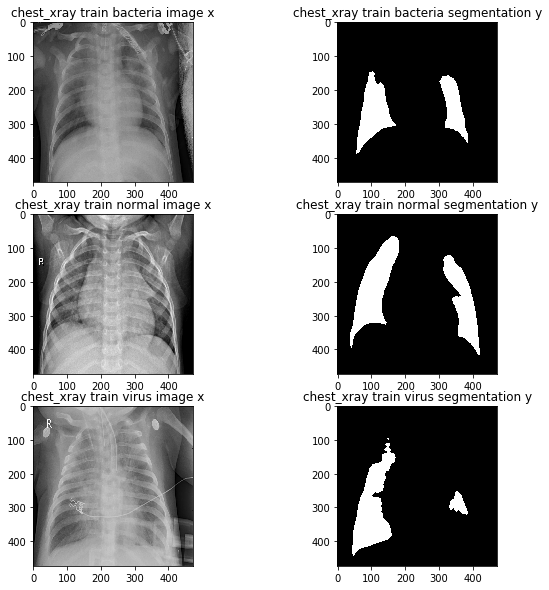

In [0]:
# VISUALIZEE SEGMENTATION RESULTS ON MontgomerySet and cxr
# visualize_MS_segmentation(lungseg, subset='train')
visualize_cxr_segmentation(lungseg, subset='train')

**Save ROI images**

In [0]:
count = 0
for folder in ['train', 'validation', 'test']:
  for subfolder in ['virus', 'bacteria']:
    dirs = os.listdir(os.path.join('/content/gdrive/My Drive/ECE1512/chest_xray/', folder, subfolder))
    print(folder, subfolder, len(dirs))
    count += len(dirs)
print(count)

count = 0
for folder in ['train', 'validation', 'test']:
  for subfolder in ['virus', 'bacteria']:
    dirs = os.listdir(os.path.join('/content/gdrive/My Drive/ECE1512/chest_xray/dataset/', folder, subfolder))
    print(folder, subfolder, len(dirs))
    count += len(dirs)
print(count)

train virus 1196
train bacteria 2358
validation virus 149
validation bacteria 192
test virus 148
test bacteria 242
4285
train virus 0
train bacteria 2358
validation virus 149
validation bacteria 192
test virus 148
test bacteria 242
3089


In [0]:
# SAVE ROI IMAGES
from tqdm import tqdm
import cv2

folders = ['train', 'validation', 'test']
subfolders = ['bacteria', 'normal', 'virus']

# make folders
for folder in folders:
  folder_path = '/content/gdrive/My Drive/ECE1512/chest_xray/dataset/' + folder
  if not os.path.exists(folder_path):
    os.mkdir(folder_path)
  for subfolder in subfolders:
    subfolder_path = '/content/gdrive/My Drive/ECE1512/chest_xray/dataset/' + folder + '/' + subfolder
    if not os.path.exists(subfolder_path):
      os.mkdir(subfolder_path)

# produce masked images
for folder in ['train']:
  for subfolder in ['virus']:
    # print("Working on", folder, subfolder)
    dirs = os.listdir(os.path.join('/content/gdrive/My Drive/ECE1512/chest_xray/', folder, subfolder))
    pbar = tqdm(total=len(dirs))
    for image_name in dirs:
      pbar.update(1)
      x = cv2.resize(cv2.imread(os.path.join('/content/gdrive/My Drive/ECE1512/chest_xray', folder, subfolder, image_name)), (473, 473))
      y = lungseg.predict_segmentation(x)
      masked = np.copy(x)
      masked[y == 0] = 0
      target_subfolder = os.path.join('/content/gdrive/My Drive/ECE1512/chest_xray/dataset/', folder, subfolder)
      cv2.imwrite(os.path.join(target_subfolder, image_name), masked)
    pbar.close()

100%|██████████| 1196/1196 [16:31<00:00,  1.23it/s]
